In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
import sys ; sys.path.append("../")
from utils.pyfunctions import *

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Setup your client
client = Client(cluster)

/glade/u/home/linnia/miniconda3/envs/ppe-py/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [4]:
la=xr.open_dataset('../utils/sparsegrid_landarea.nc').landarea

In [5]:
def preprocess(ds):
    dvs=['TLAI','TWS','GPP','NPP','TOTVEGC','TOTSOMC','TOTECOSYSC']
    return ds[dvs]

In [6]:
def readin_postSASU(path,preprocess,startyear):
    files =glob.glob(path+'*.h0.*')
    f=sorted(files)

    ds=xr.open_mfdataset(f,combine='nested',concat_dim=['time'],
                     preprocess=preprocess,decode_times=False,parallel=True)
    ds['time']=xr.cftime_range(str(startyear),periods=len(ds.time),freq='MS',calendar='noleap')
    return ds

In [8]:
# readin double spinup postSASU
path = '/glade/derecho/scratch/linnia/ctsm5.3.0_transient_postSASU_test0017/run/' # xl max
#path = '/glade/derecho/scratch/linnia/ctsm5.3.0_transient_postSASU_test0015/run/' # leafcn max
ds_double = readin_postSASU(path,preprocess,1770)

In [31]:
# readin normal (single) spinup postSASU
path = '/glade/derecho/scratch/linnia/ctsm5.3.010_transient_postSASU_test0031/run/' # xl max
#path = '/glade/derecho/scratch/linnia/ctsm5.3.0_transient_postSASU_test0016/run/' # xl max
#path = '/glade/derecho/scratch/linnia/ctsm5.3.0_transient_postSASU_test0014/run/' # leafcn max
ds_single = readin_postSASU(path,preprocess,1810)

In [18]:
# readin normal (single) spinup postSASU for default parameter set
path = '/glade/derecho/scratch/linnia/ctsm5.3.010_transient_postSASU_test0029/run/' 
ds_default = readin_postSASU(path,preprocess,1810)

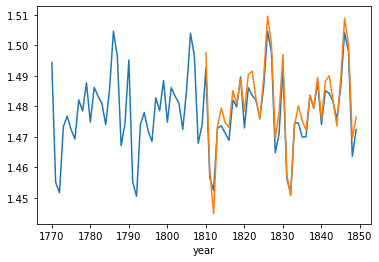

In [9]:
gmean(amean(ds_double['TLAI']),la).plot()
gmean(amean(ds_single['TLAI']),la).plot()

In [29]:
### Calc delta between met recycling iterations
dvs=['TLAI','TWS','GPP','NPP','TOTVEGC','TOTSOMC','TOTECOSYSC']
cfs = [1,1,60*60*24*365*1e-9*la.sum().values,60*60*24*365*1e-9*la.sum().values,1e-9*la.sum().values,1e-9*la.sum().values,1e-9*la.sum().values]
data = []
for i,var in enumerate(dvs):

    da = cfs[i]*gmean(amean(ds_single[var]),la)
    #da = cfs[i]*gmean(amean(ds_default[var]),la)
    delta1=(da-da.shift(year=20)).isel(year=range(20,40)).mean(dim='year')/20

    da = cfs[i]*gmean(amean(ds_double[var]),la).isel(year=range(40,80))
    delta2=(da-da.shift(year=20)).isel(year=range(20,40)).mean(dim='year')/20

    data.append([delta1.values, delta2.values])

pSASU_delta = pd.DataFrame(data,index=dvs,columns=['Single spinup','Double spinup'])

In [30]:
pSASU_delta

,Single spinup,Double spinup
TLAI,8.826558284689756e-05,3.127439399897014e-08
TWS,0.0279534663938648,0.02568606422008088
GPP,-0.001741210822281154,-0.00036977832271745115
NPP,0.0006340181758775288,0.0003677370613633357
TOTVEGC,0.04154516261121444,-0.00021783224399058555
TOTSOMC,0.04003074390767551,-3.6754070202960064e-05
TOTECOSYSC,0.14452121729253917,-0.0009536435058191729


### fraction of land area in disequilibrium

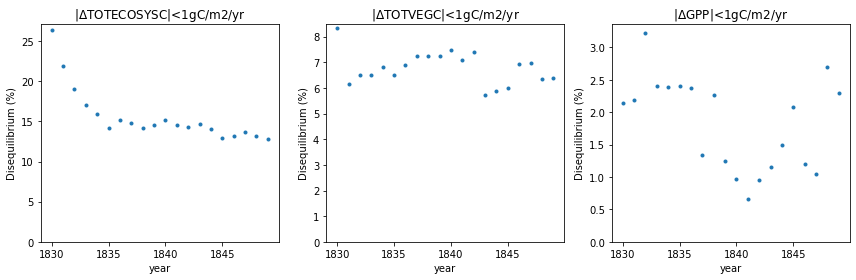

In [32]:
# single spinup
dvs = ['TOTECOSYSC','TOTVEGC','GPP']
cfs = [1,1,24*60*60*365]

plt.figure(figsize=(12,4))
for i,var in enumerate(dvs):
    da=cfs[i]*amean(ds_single[var])
    #da=cfs[i]*amean(ds_default[var])
    dx=abs(da-da.shift(year=20)).isel(year=range(20,40))
    diseq=(la*(dx>20)).sum(dim='gridcell')/la.sum()
    
    plt.subplot(1,3,i+1)
    (100*diseq).plot.line('.')
    plt.ylim(bottom=0)
    plt.ylabel('Disequilibrium (%)')
    plt.title('|$\Delta$'+var+'|<1gC/m2/yr');
    
plt.tight_layout()
plt.savefig('../figs/Spatial_disequilibrium_40AD120SASU_leafcn_max.png')

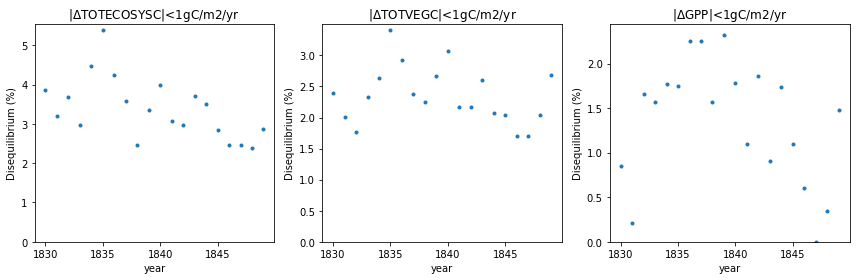

In [13]:
# Double spinup
dvs = ['TOTECOSYSC','TOTVEGC','GPP']
cfs = [1,1,24*60*60*365]

plt.figure(figsize=(12,4))
for i,var in enumerate(dvs):

    da=cfs[i]*amean(ds_double[var]).isel(year=range(40,80))
    dx=abs(da-da.shift(year=20)).isel(year=range(20,40))
    diseq=(la*(dx>20)).sum(dim='gridcell')/la.sum()
    
    plt.subplot(1,3,i+1)
    (100*diseq).plot.line('.')
    plt.ylim(bottom=0)
    plt.ylabel('Disequilibrium (%)')
    plt.title('|$\Delta$'+var+'|<1gC/m2/yr');
    
plt.tight_layout()
plt.savefig('../figs/Spatial_disequilibrium_2Xspinup_xl_max.png')

### Check SASU to postSASU jumps

In [19]:
def readin_SASU(path,preprocess,startyear):
    files =glob.glob(path+'*.h0.*')
    f=sorted(files)

    ds=xr.open_mfdataset(f,combine='nested',concat_dim=['time'],
                     preprocess=preprocess,decode_times=False,parallel=True)
    ds['time']=xr.cftime_range(str(startyear),periods=len(ds.time),freq='1Y',calendar='noleap')
    return ds

In [20]:
path = '/glade/derecho/scratch/linnia/ctsm5.3.0_transient_SASU_test0014/run/' 
ds_SASU = readin_SASU(path,preprocess,1730)

In [21]:
lai_SASU = gmean(ds_SASU.TLAI,la)

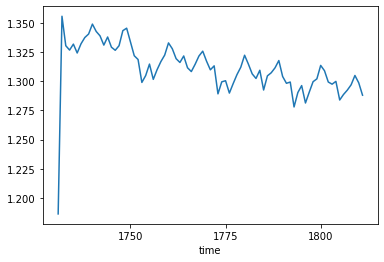

In [22]:
lai_SASU.plot()

In [23]:
path = '/glade/derecho/scratch/linnia/ctsm5.3.0_transient_postSASU_test0014/run/' # leafcn max
ds_pSASU = readin_postSASU(path,preprocess,1770)

In [24]:
lai_pSASU = gmean(amean(ds_pSASU.TLAI),la)
lai_pSASU = lai_pSASU.rename({'year': 'time'})

In [26]:
lai_pSASU

<xarray.DataArray (time: 40)>
array([1.28985634, 1.27091399, 1.28197147, 1.28618474, 1.27676614,
       1.28391077, 1.29212523, 1.29268993, 1.302268  , 1.29643261,
       1.29056875, 1.29004461, 1.29495743, 1.27734577, 1.28407425,
       1.28772173, 1.29077989, 1.30050062, 1.29141853, 1.28448899,
       1.27964296, 1.26356658, 1.27707009, 1.28746317, 1.27385496,
       1.27586823, 1.28055068, 1.28842704, 1.30054231, 1.29365517,
       1.28664841, 1.28424351, 1.2889656 , 1.27179311, 1.27679703,
       1.28153592, 1.28504356, 1.29228177, 1.28675573, 1.28417471])
Coordinates:
  * time     (time) int64 1770 1771 1772 1773 1774 ... 1805 1806 1807 1808 1809

In [29]:
lai = xr.concat([lai_SASU,lai_pSASU],dim='time')

In [32]:
np.shape(lai)

(121,)

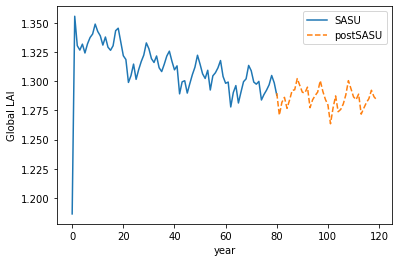

In [34]:
plt.plot(range(81),lai_SASU,label='SASU')
plt.plot(range(80,80+40),lai_pSASU,linestyle='--',label='postSASU')
plt.xlabel('year')
plt.ylabel('Global LAI')
plt.legend()